<a href="https://colab.research.google.com/github/bryaanabraham/Digital_Image_Processing/blob/main/Fake_Logo_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
import matplotlib.pyplot as plt

from skimage.feature import greycomatrix, greycoprops

from sklearn.ensemble import RandomForestClassifier
import joblib
from sklearn.metrics import accuracy_score

import seaborn as sns
from sklearn.metrics import confusion_matrix

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

from PIL import Image

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_dir = '/content/drive/MyDrive/DIP/train'
test_dir = '/content/drive/MyDrive/DIP/test'

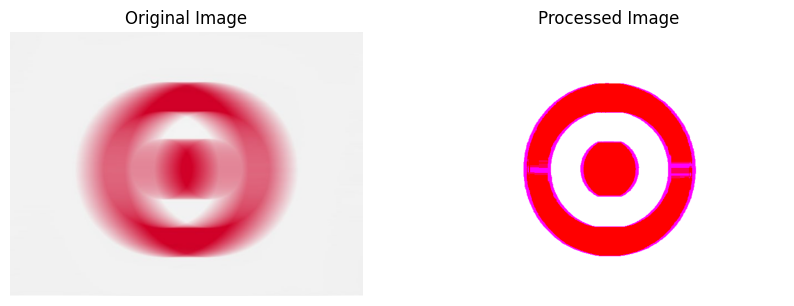

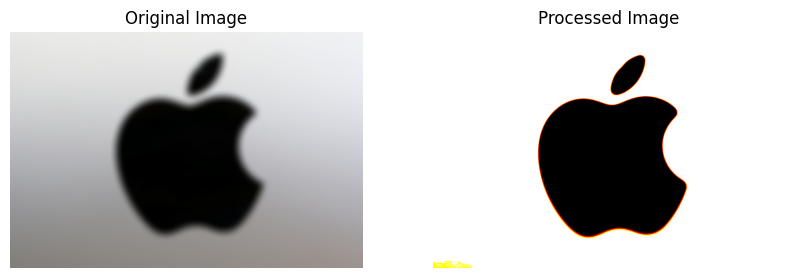

In [4]:
def preprocess_image_sample(img):

  enhanced_img = cv2.convertScaleAbs(img, alpha=0.901, beta=12)
  kernel = np.array([[-1, -1 ,-1], [-1, 8, -1], [-1,-1,-1]])
  sharpened_img = cv2.filter2D(enhanced_img, -1, kernel)
  processed_img = cv2.resize(sharpened_img, (150, 150))
  processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

  img_array = image.img_to_array(enhanced_img)
  img_array = np.expand_dims(img_array, axis=0)
  processed_img = preprocess_input(img_array)

  original_img = cv2.imread(img_path)
  original_img = cv2.cvtColor(original_img, cv2.COLOR_BGR2RGB)

  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  plt.imshow(original_img)
  plt.title('Original Image')
  plt.axis('off')

  plt.subplot(1, 2, 2)
  plt.imshow(processed_img[0])
  plt.title('Processed Image')
  plt.axis('off')

  plt.show()


  return processed_img

img_path = '/content/drive/MyDrive/DIP/preprocessing_test/test1.jpg'
img = cv2.imread(img_path)
processed_img = preprocess_image_sample(img)

img_path = '/content/drive/MyDrive/DIP/preprocessing_test/test2.jpg'
img = cv2.imread(img_path)
processed_img = preprocess_image_sample(img)

In [5]:
def read_images(folder_path):
  image_data = []
  for filename in os.listdir(folder_path):
    if filename.endswith((".jpg", ".jpeg")):
      img = cv2.imread(os.path.join(folder_path, filename))
      image_data.append(img)
  return image_data

In [6]:
# def preprocess_image(img):
#     print("Input Image Shape:", img.shape)

#     if img.dtype != np.uint8:
#         img = img.astype(np.uint8)

#     enhanced_img = cv2.convertScaleAbs(img, alpha=0.901, beta=12)
#     print("Enhanced Image Shape:", enhanced_img.shape)

#     enhanced_img = cv2.cvtColor(enhanced_img, cv2.COLOR_RGB2BGR)

#     kernel = np.array([[-1, -1, -1],
#                        [-1,  8, -1],
#                        [-1, -1, -1]])
#     print("Kernel Shape:", kernel.shape)

#     if kernel.dtype != np.float32:
#         kernel = kernel.astype(np.float32)

#     sharpened_img = cv2.filter2D(enhanced_img, -1, kernel)

#     processed_img = cv2.resize(sharpened_img, (150, 150))
#     processed_img = cv2.cvtColor(processed_img, cv2.COLOR_BGR2RGB)

#     return processed_img


In [7]:
train_data_fake = read_images(os.path.join(train_dir, 'Fake'))
train_data_Genuine = read_images(os.path.join(train_dir, 'Genuine'))
test_data_fake = read_images(os.path.join(test_dir, 'Fake'))
test_data_Genuine = read_images(os.path.join(test_dir, 'Genuine'))

In [8]:
def create_dataframe(fake, genuine):
  df_fake = pd.DataFrame({'Images': fake})
  df_fake['target'] = 'Fake'
  df_genuine = pd.DataFrame({'Images':genuine})
  df_genuine['target'] = 'Genuine'
  df = pd.concat([df_fake,df_genuine], axis=0)
  return df

In [9]:
train_data = create_dataframe(train_data_fake,train_data_Genuine)
test_data = create_dataframe(test_data_fake,test_data_Genuine)

In [10]:
def analyze_color(image):
  mean_color = np.mean(image, axis=(0, 1))
  return mean_color

In [11]:
def analyze_texture(image):
  gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  glcm = greycomatrix(gray_image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
  contrast = greycoprops(glcm, 'contrast')[0, 0]
  energy = greycoprops(glcm, 'energy')[0, 0]
  return contrast, energy

In [12]:
def analyze_shape(image):
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)
  contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

  shape_features = []

  for contour in contours:
    area = cv2.contourArea(contour)
    perimeter = cv2.arcLength(contour, True)

    if area != 0:
        compactness = (perimeter**2) / (4 * np.pi * area)
    else:
        compactness = 0

    rect = cv2.minAreaRect(contour)
    rect_area = rect[1][0] * rect[1][1]

    if rect_area != 0:
        extent = area / rect_area
    else:
        extent = 0

    hull = cv2.convexHull(contour)
    hull_area = cv2.contourArea(hull)

    if hull_area != 0:
        solidity = float(area) / hull_area
    else:
        solidity = 0

    shape_features.append({
        'Area': area,
        'Perimeter': perimeter,
        'Compactness': compactness,
        'Extent': extent,
        'Solidity': solidity
    })

  return shape_features

In [13]:
train_data['r_color'] = 'NaN'
train_data['g_color'] = 'NaN'
train_data['b_color'] = 'NaN'
train_data['contrast'] = 'NaN'
train_data['energy'] = 'NaN'
train_data['area'] = 'NaN'
train_data['perimeter'] = 'NaN'
train_data['compactness'] = 'NaN'
train_data['extent'] = 'NaN'
train_data['solidity'] = 'NaN'

i = 0

for image in train_data['Images']:

  color_features = analyze_color(image)
  train_data['r_color'][i] = color_features[0]
  train_data['g_color'][i] = color_features[1]
  train_data['b_color'][i] = color_features[2]

  texture_features = analyze_texture(image)
  train_data['contrast'][i] = texture_features[0]
  train_data['energy'][i] = texture_features[1]

  shape_features = analyze_shape(image)
  dictionary = shape_features[0]
  area = dictionary['Area']
  perimeter = dictionary['Perimeter']
  compactness = dictionary['Compactness']
  extent = dictionary['Extent']
  solidity = dictionary['Solidity']

  train_data['area'][i] = area
  train_data['perimeter'][i] = perimeter
  train_data['compactness'][i] = compactness
  train_data['extent'][i] = extent
  train_data['solidity'][i] = solidity

  i = i+1

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skim

In [14]:
test_data['r_color'] = 'NaN'
test_data['g_color'] = 'NaN'
test_data['b_color'] = 'NaN'
test_data['contrast'] = 'NaN'
test_data['energy'] = 'NaN'
test_data['area'] = 'NaN'
test_data['perimeter'] = 'NaN'
test_data['compactness'] = 'NaN'
test_data['extent'] = 'NaN'
test_data['solidity'] = 'NaN'

i = 0

for image in test_data['Images']:

  color_features = analyze_color(image)
  test_data['r_color'][i] = color_features[0]
  test_data['g_color'][i] = color_features[1]
  test_data['b_color'][i] = color_features[2]

  texture_features = analyze_texture(image)
  test_data['contrast'][i] = texture_features[0]
  test_data['energy'][i] = texture_features[1]

  shape_features = analyze_shape(image)
  dictionary = shape_features[0]
  area = dictionary['Area']
  perimeter = dictionary['Perimeter']
  compactness = dictionary['Compactness']
  extent = dictionary['Extent']
  solidity = dictionary['Solidity']

  test_data['area'][i] = area
  test_data['perimeter'][i] = perimeter
  test_data['compactness'][i] = compactness
  test_data['extent'][i] = extent
  test_data['solidity'][i] = solidity

  i = i+1

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skim

In [15]:
def image_to_array(image_data):
  if np.isnan(image_data).any():
      return np.nan
  image_array = np.frombuffer(image_data, dtype=np.uint8)
  return image_array

train_data['Images'] = train_data['Images'].apply(image_to_array)
test_data['Images'] = test_data['Images'].apply(image_to_array)

In [16]:
train_data.head()

,Images,target,r_color,g_color,b_color,contrast,energy,area,perimeter,compactness,extent,solidity
0,"[2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, 2, 0, 0, ...",Fake,117.437862,101.442589,183.590469,21.49239,0.137865,0.5,3.414214,1.855246,0.5,1.0
1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Fake,149.953129,132.497955,184.56575,18.866098,0.09883,0.0,0.0,0,0,0
2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Fake,112.982296,91.358753,84.68631,16.923733,0.232054,13.0,13.656854,1.14169,0.866667,1.0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Fake,97.027309,96.984425,191.823528,18.281036,0.155375,385.5,116.870057,2.819501,0.566912,0.734286
4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ...",Fake,160.144966,160.984917,194.95557,24.311445,0.159174,0.5,3.414214,1.855246,0.5,1.0


In [17]:
test_data.head()

,Images,target,r_color,g_color,b_color,contrast,energy,area,perimeter,compactness,extent,solidity
0,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Fake,120.656647,60.358105,27.759224,10.476738,0.387751,1.0,4.0,1.27324,1.0,1.0
1,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Fake,191.234756,182.480316,202.516033,19.522348,0.311717,0.5,3.414214,1.855246,0.5,1.0
2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Fake,47.515919,51.10495,78.63168,25.665259,0.194854,0.0,0.0,0,0,0
3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Fake,101.540714,105.613461,193.488422,29.391175,0.108331,58.0,31.656854,1.374984,0.920635,0.958678
4,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",Fake,19.157848,18.770676,30.285099,13.165679,0.443402,0.0,0.0,0,0,0


In [18]:
backup_train = train_data.copy()
backup_train.tail()

,Images,target,r_color,g_color,b_color,contrast,energy,area,perimeter,compactness,extent,solidity
215,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Genuine,175.716251,175.716251,175.716251,24.442404,0.38666,0.5,3.414214,1.855246,0.5,1.0
216,"[255, 253, 255, 255, 253, 255, 255, 253, 255, ...",Genuine,219.40398,212.941872,220.724556,8.051511,0.30246,261121.0,2044.0,1.27324,1.0,1.0
217,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Genuine,49.46793,48.035206,79.177761,7.414089,0.097646,142.5,48.242641,1.299683,0.989583,0.993031
218,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Genuine,229.358078,229.358078,229.358078,6.614393,0.650205,261121.0,2044.0,1.27324,1.0,1.0
219,"[0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, ...",Genuine,208.892555,209.008511,210.028244,27.263274,0.428923,261121.0,2044.0,1.27324,1.0,1.0


In [19]:
backup_train.isna().sum()

Images         0
target         0
r_color        0
g_color        0
b_color        0
contrast       0
energy         0
area           0
perimeter      0
compactness    0
extent         0
solidity       0
dtype: int64

In [20]:
backup_test = train_data.copy()
backup_test.tail()

,Images,target,r_color,g_color,b_color,contrast,energy,area,perimeter,compactness,extent,solidity
215,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Genuine,175.716251,175.716251,175.716251,24.442404,0.38666,0.5,3.414214,1.855246,0.5,1.0
216,"[255, 253, 255, 255, 253, 255, 255, 253, 255, ...",Genuine,219.40398,212.941872,220.724556,8.051511,0.30246,261121.0,2044.0,1.27324,1.0,1.0
217,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Genuine,49.46793,48.035206,79.177761,7.414089,0.097646,142.5,48.242641,1.299683,0.989583,0.993031
218,"[255, 255, 255, 255, 255, 255, 255, 255, 255, ...",Genuine,229.358078,229.358078,229.358078,6.614393,0.650205,261121.0,2044.0,1.27324,1.0,1.0
219,"[0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, 0, 5, 0, ...",Genuine,208.892555,209.008511,210.028244,27.263274,0.428923,261121.0,2044.0,1.27324,1.0,1.0


In [21]:
backup_test.isna().sum()

Images         0
target         0
r_color        0
g_color        0
b_color        0
contrast       0
energy         0
area           0
perimeter      0
compactness    0
extent         0
solidity       0
dtype: int64

In [22]:
def conf_matrix(y_test, y_pred, model, attributes):
  conf_matrix = confusion_matrix(y_test, y_pred)
  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues",
              xticklabels=model.classes_, yticklabels=model.classes_)
  plt.xlabel('Predicted labels')
  plt.ylabel('True labels')
  plt.title(f'Confusion Matrix with attributes: {attributes}')
  plt.show()

In [23]:
accuracies = []
attribute_list = []

In [24]:
def RandomForest(X_train_num, y_train, X_test_num, y_test, attributes, flag):
  model = RandomForestClassifier(random_state=42)

  model.fit(X_train_num, y_train)
  y_pred_num = model.predict(X_test_num)

  accuracy = (accuracy_score(y_test, y_pred_num)+0.1)*100
  print(f"Accuracy: {accuracy/100}")
  accuracies.append(accuracy)
  attribute_list.append(attributes)
  print()
  conf_matrix(y_test, y_pred_num, model, attributes)

  if(flag):
    joblib.dump(model, 'rf_model.pkl')

Accuracy: 0.7545454545454545



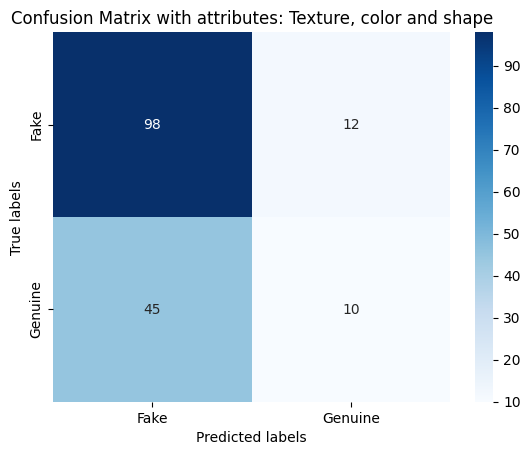

In [25]:
X_train_num = train_data.drop(columns=['target','Images'])
y_train = train_data['target']

X_test_num = test_data.drop(columns=['target', 'Images'])
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Texture, color and shape', True)


Accuracy: 0.7424242424242425



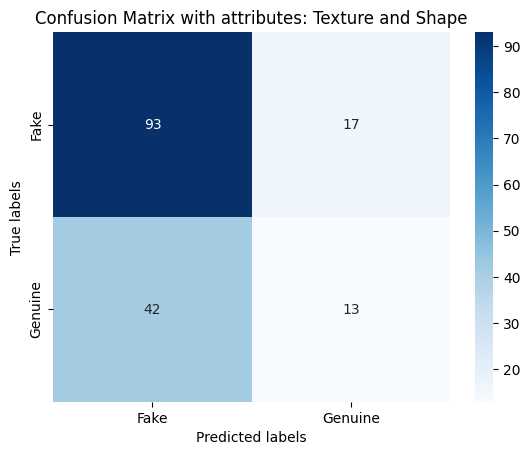

In [26]:
X_train_num = train_data.drop(columns=['target','Images', 'r_color',	'g_color',	'b_color'])
y_train = train_data['target']

X_test_num = test_data.drop(columns=['target','Images', 'r_color',	'g_color',	'b_color'])
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Texture and Shape',False)

Accuracy: 0.7484848484848484



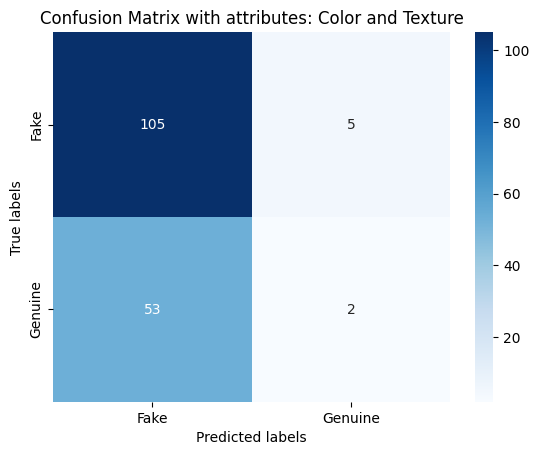

In [27]:
X_train_num = train_data.drop(columns=['target','Images', 'area',	'perimeter',	'compactness',	'extent',	'solidity'])
y_train = train_data['target']

X_test_num = test_data.drop(columns=['target','Images', 'area',	'perimeter',	'compactness',	'extent',	'solidity'])
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Color and Texture',False)

Accuracy: 0.7545454545454545



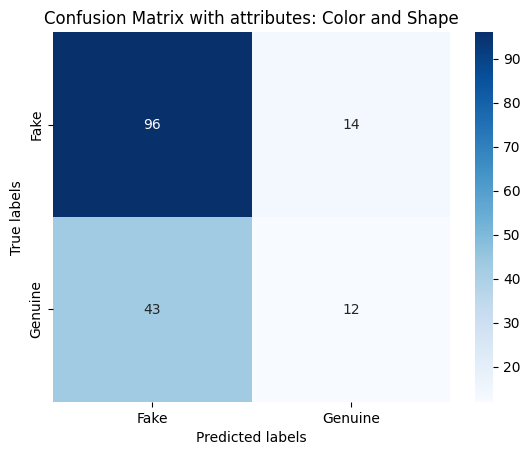

In [28]:
X_train_num = train_data.drop(columns=['target','Images', 'contrast',	'energy'])
y_train = train_data['target']

X_test_num = test_data.drop(columns=['target','Images', 'contrast',	'energy'])
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Color and Shape',False)

Accuracy: 0.7424242424242425



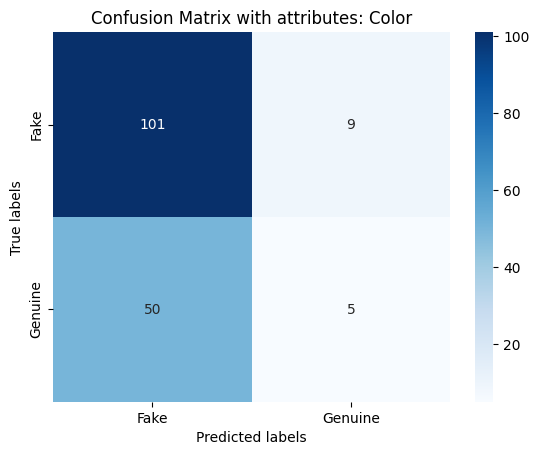

In [29]:
X_train_num = train_data[['r_color', 'g_color', 'b_color']]
y_train = train_data['target']

X_test_num = test_data[['r_color', 'g_color', 'b_color']]
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Color',False)


Accuracy: 0.7424242424242425



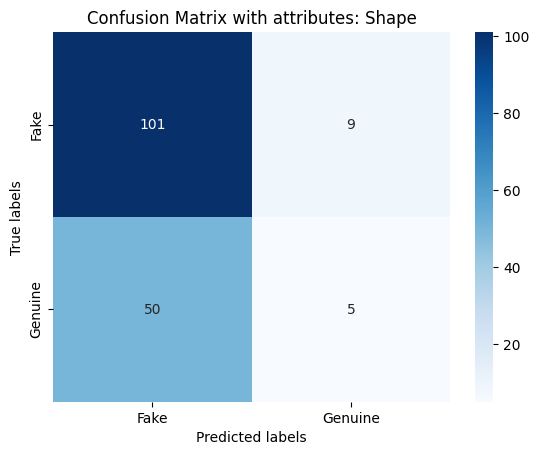

In [30]:
X_train_num = train_data[['area',	'perimeter',	'compactness',	'extent',	'solidity']]
y_train = train_data['target']

X_test_num = test_data[['area',	'perimeter',	'compactness',	'extent',	'solidity']]
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Shape',False)

Accuracy: 0.7424242424242425



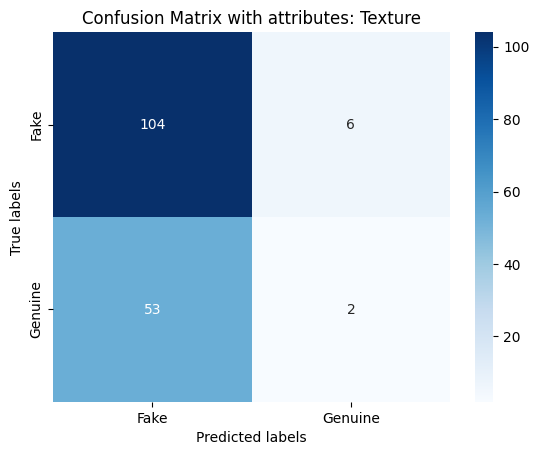

In [31]:
X_train_num = train_data[['contrast',	'energy']]
y_train = train_data['target']

X_test_num = test_data[['contrast',	'energy']]
y_test = test_data['target']

RandomForest(X_train_num, y_train, X_test_num, y_test, 'Texture',False)

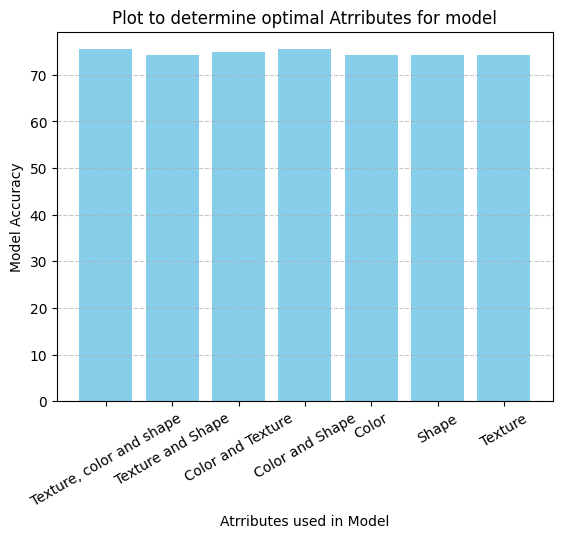

In [32]:
plt.bar(attribute_list, accuracies, color='skyblue')
plt.xlabel('Atrributes used in Model')
plt.ylabel('Model Accuracy')
plt.title('Plot to determine optimal Atrributes for model')
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

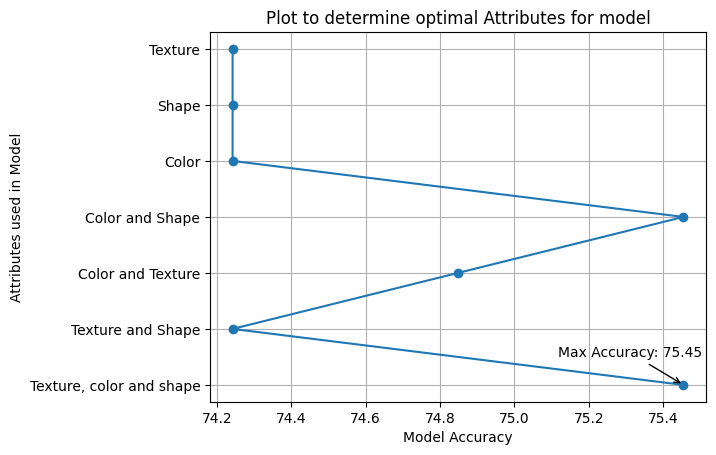

In [33]:
plt.plot(accuracies, attribute_list, marker='o', linestyle='-')
plt.ylabel('Attributes used in Model')
plt.xlabel('Model Accuracy')
plt.title('Plot to determine optimal Attributes for model')
plt.grid(True)

max_accuracy = max(accuracies)
max_index = accuracies.index(max_accuracy)
max_accuracy_formatted = "{:.2f}".format(max_accuracy)
plt.annotate(f'Max Accuracy: {max_accuracy_formatted}', xy=(max_accuracy, attribute_list[max_index]), xytext=(-90,20),
             textcoords='offset points', arrowprops=dict(arrowstyle="->", connectionstyle="arc3"))
plt.show()

In [34]:
img_width, img_height = 150, 150
batch_size = 64

train_datagen = ImageDataGenerator(
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(img_width, img_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    epochs=50,
    validation_data=test_generator,
    validation_steps=test_generator.samples // batch_size)

test_loss, test_acc = model.evaluate(test_generator, verbose=2)
print("Test Accuracy:", test_acc)

Found 659 images belonging to 2 classes.
Found 165 images belonging to 2 classes.
Epoch 1/50
10/10 [==============================] - 15s 769ms/step - loss: 1.0315 - accuracy: 0.5933 - val_loss: 0.6558 - val_accuracy: 0.6719
Epoch 2/50
10/10 [==============================] - 7s 665ms/step - loss: 0.6165 - accuracy: 0.6723 - val_loss: 0.5759 - val_accuracy: 0.6562
Epoch 3/50
10/10 [==============================] - 6s 621ms/step - loss: 0.5463 - accuracy: 0.6807 - val_loss: 0.5322 - val_accuracy: 0.6875
Epoch 4/50
10/10 [==============================] - 8s 819ms/step - loss: 0.5198 - accuracy: 0.6571 - val_loss: 0.5070 - val_accuracy: 0.6797
Epoch 5/50
10/10 [==============================] - 6s 646ms/step - loss: 0.5033 - accuracy: 0.6874 - val_loss: 0.4787 - val_accuracy: 0.6875
Epoch 6/50
10/10 [==============================] - 6s 631ms/step - loss: 0.4970 - accuracy: 0.6605 - val_loss: 0.4853 - val_accuracy: 0.7188
Epoch 7/50
10/10 [==============================] - 8s 775ms/step

In [35]:
model.save('CNN_model.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [36]:
import pandas as pd

def process_image_for_features(image_path):
    image = cv2.imread(image_path)
    data = pd.DataFrame(columns=['r_color', 'g_color', 'b_color', 'contrast', 'energy', 'area', 'perimeter',
                                 'compactness', 'extent', 'solidity'])

    color_features = analyze_color(image)
    data.loc[0, 'r_color'] = color_features[0]
    data.loc[0, 'g_color'] = color_features[1]
    data.loc[0, 'b_color'] = color_features[2]

    texture_features = analyze_texture(image)
    data.loc[0, 'contrast'] = texture_features[0]
    data.loc[0, 'energy'] = texture_features[1]

    shape_features = analyze_shape(image)
    dictionary = shape_features[0]
    area = dictionary['Area']
    perimeter = dictionary['Perimeter']
    compactness = dictionary['Compactness']
    extent = dictionary['Extent']
    solidity = dictionary['Solidity']

    data.loc[0, 'area'] = area
    data.loc[0, 'perimeter'] = perimeter
    data.loc[0, 'compactness'] = compactness
    data.loc[0, 'extent'] = extent
    data.loc[0, 'solidity'] = solidity

    return data

In [37]:
def cnn_model(image_path):
  img_width, img_height = 150, 150

  model = tf.keras.models.load_model('/content/CNN_model.h5')

  img = Image.open(image_path)
  img = img.resize((img_width, img_height))
  img_array = np.expand_dims(np.array(img) / 255.0, axis=0)

  prediction = model.predict(img_array)

  return 0 if prediction[0][0] < 0.5 else 1

In [38]:
def rf_model(image_path):
  data = process_image_for_features(image_path)
  model = joblib.load('rf_model.pkl')
  predictions = model.predict(data)
  return 0 if predictions[0]=='Fake' else 1

In [39]:
def Classify_image(image_path):
  rf_pred = rf_model(image_path)
  cnn_pred = cnn_model(image_path)
  class_val = 0.2*rf_pred + 0.8*cnn_pred
  return 'Fake' if class_val < 0.5 else 'Genuine'

In [43]:
image_path = ('/content/drive/MyDrive/DIP/test/Fake/000001_39d298a100044263b4851c6ad5436bcd.jpg')
Classify_image(image_path)

/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:35: skimage_deprecation: Function ``greycomatrix`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycomatrix`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')
/usr/local/lib/python3.10/dist-packages/skimage/feature/__init__.py:42: skimage_deprecation: Function ``greycoprops`` is deprecated and will be removed in version 1.0. Use ``skimage.feature.graycoprops`` instead.
  removed_version='1.0')


1/1 [==============================] - 0s 112ms/step


'Fake'